# Scripts to Generate Data

The following scripts generate our dataset.

The images and corresponding masks are sampled from the Google Static Maps API. 

## Dependencies

In [ ]:
pip install Pillow requests matplotlib geopandas osmnx

In [2]:
import requests
from PIL import Image, ImageDraw
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
import math

# API Functions

In [6]:
def download_satellite_image(lat, lon, zoom, size=400, maptype='satellite', api_key='YOUR_GOOGLE_MAPS_API_KEY'):
    original_size = (size, size + 23)  # Increased height by 23 pixels
    final_size = (size, size)          # Final size after cropping

    url = (
        f"https://maps.googleapis.com/maps/api/staticmap?"
        f"center={lat},{lon}&zoom={zoom}&size={original_size[0]}x{original_size[1]}&maptype={maptype}&key={api_key}"
    )
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(io.BytesIO(response.content))
        # Crop the bottom 23 pixels to make the image size x size
        cropped_image = image.crop((0, 0, final_size[0], final_size[1]))
        return cropped_image
    else:
        raise Exception(f"Error fetching the image from Google Maps API: {response.status_code}")

    
def download_mask(lat, lon, zoom, api_key='YOUR_GOOGLE_MAPS_API_KEY'):
    original_size = (400, 423)  # Increased height by 23 pixels
    final_size = (400, 400)     # Final size after cropping

    url = (
        f"https://maps.googleapis.com/maps/api/staticmap?"
        f"key={api_key}&center={lat},{lon}&zoom={zoom}&format=png&maptype=roadmap"
        f"&style=element:labels|visibility:off"
        f"&style=feature:administrative|element:geometry|visibility:off"
        f"&style=feature:administrative.land_parcel|visibility:off"
        f"&style=feature:administrative.neighborhood|visibility:off"
        f"&style=feature:landscape|element:geometry|color:0x000000"
        f"&style=feature:poi|visibility:off"
        f"&style=feature:road|element:geometry.fill|color:0xffffff"
        f"&style=feature:road|element:geometry.stroke|color:0xffffff"
        f"&style=feature:road|element:labels.icon|visibility:off"
        f"&style=feature:transit|visibility:off"
        f"&style=feature:water|element:geometry|color:0x000000"
        f"&size={original_size[0]}x{original_size[1]}"
    )
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(io.BytesIO(response.content))
        # Crop the bottom 23 pixels to make the image 400x400
        cropped_image = image.crop((0, 0, final_size[0], final_size[1]))
        return cropped_image
    else:
        raise Exception(f"Error fetching the image from Google Maps API: {response.status_code}")


# Code to Generate Dataset

In [10]:
# Helper function to create directory if it does not exist
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def generate_image_grid(name, center_lat, center_lng, api_key, output_image_dir, output_mask_dir,width_km=1.0, height_km=0.5, image_size=400, zoom=18):
    meters_per_px = 0.441442  # meters per pixel at zoom level 18
    image_side_meters = image_size * meters_per_px
    
    num_images_horizontally = math.ceil((width_km * 1000) / image_side_meters)
    num_images_vertically = math.ceil((height_km * 1000) / image_side_meters)
    total_images = num_images_horizontally * num_images_vertically
    
    lat_change_per_image = image_side_meters / 111320
    lng_change_per_image = image_side_meters / (111320 * math.cos(center_lat * math.pi / 180))
    
    ensure_dir(output_image_dir)
    ensure_dir(output_mask_dir)
    
    id=0
    for i in range(num_images_vertically):
        for j in range(num_images_horizontally):
            lat = center_lat + (i - num_images_vertically / 2) * lat_change_per_image
            lng = center_lng + (j - num_images_horizontally / 2) * lng_change_per_image
            
            try:
                satellite_image = download_satellite_image(lat, lng, zoom, api_key=api_key)
                mask_image = download_mask(lat, lng, zoom, api_key=api_key)
                
                satellite_image.save(f"{output_image_dir}/im_{name}_{id}.png")
                mask_image.save(f"{output_mask_dir}/mask_{name}_{id}.png")
                
                print(f"Downloaded image {id}/{total_images} at position lat: {lat}, lng: {lng}")
            except Exception as e:
                print(f"Error downloading images for lat: {lat}, lng: {lng} - {e}")
            id+=1


# 

# Usage: How to generate a Dataset

## 1. Define the following Parameters

In [21]:
# Enter the Google API KEY
api_key = 'APIKEY_HERE'

#DONT CHANGE ZOOM:
zoom = 18

# Directories for output images and masks
output_image_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/boston/images'
output_mask_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/boston/groundtruth'

# define the center of the area we want to download images for
name = 'boston'
center_lat = 42.37298436808404
center_lng = -71.12997834458828

#define how many km to the left and right and up and down of the location we want to download
width_km = 10.0
height_km = 5.0

## 2. Dataset size

This function helps you find the right parameters to see how big the dataset will be

In [22]:
#calc number of generated images 
def calc_num_images(width_km, height_km, image_size):
    meters_per_px = 0.441442  # meters per pixel at zoom level 18
    image_side_meters = image_size * meters_per_px

    num_images_horizontally = math.ceil((width_km * 1000) / image_side_meters)
    num_images_vertically = math.ceil((height_km * 1000) / image_side_meters)

    #print how many images the parameters will generate at zoom level
    print (f"Total number of images: {num_images_horizontally*num_images_vertically}")

In [ ]:
width_km = 10
height_km = 5
calc_num_images(width_km, height_km, 400)

Total number of images: 1653


## 3. Test: single location

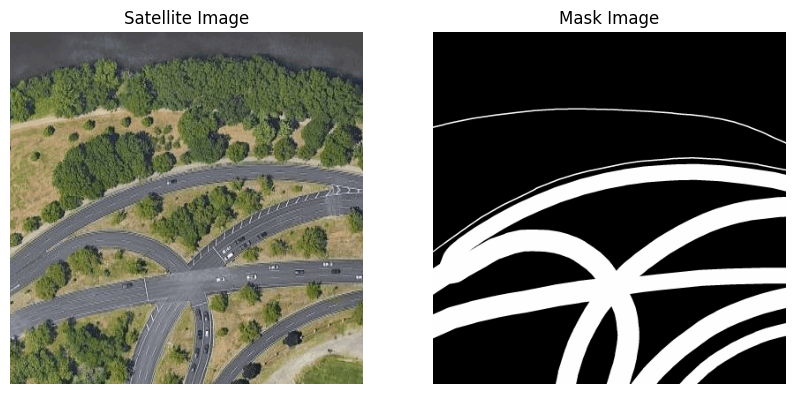

In [24]:
test_image = download_satellite_image(center_lat, center_lng, zoom, api_key=api_key)
test_mask = download_mask(center_lat, center_lng, zoom, api_key=api_key)

#plot both sat and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title('Satellite Image')
ax[1].imshow(test_mask)
ax[1].axis('off')
ax[1].set_title('Mask Image')
plt.show()

## 4. Generate the Dataset

In [ ]:
generate_image_grid(
    name, 
    center_lat, 
    center_lng, 
    api_key, 
    output_image_dir=output_image_dir, 
    output_mask_dir=output_mask_dir,
    width_km=width_km,
    height_km=height_km,
    image_size=400,
    zoom=zoom
    )

# NEW YORK

In [31]:
# Enter the Google API KEY
api_key = 'ENTER_API_KEY_HERE'

#DONT CHANGE ZOOM:
zoom = 18

# Directories for output images and masks
output_image_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/nyc/images'
output_mask_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/nyc/groundtruth'

# define the center of the area we want to download images for
name = 'nyc'
center_lat = 40.75084683829363
center_lng = -73.8540586955731

#define how many km to the left and right and up and down of the location we want to download
width_km = 13.0
height_km = 7.0

generate_image_grid(
    name, 
    center_lat, 
    center_lng, 
    api_key, 
    output_image_dir=output_image_dir, 
    output_mask_dir=output_mask_dir,
    width_km=width_km,
    height_km=height_km,
    image_size=400,
    zoom=zoom
    )

# Zurich

In [ ]:
# Enter the Google API KEY
api_key = 'ENTER_API_KEY_HERE'

#DONT CHANGE ZOOM:
zoom = 18

# Directories for output images and masks
output_image_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/zurich/images'
output_mask_dir = '/Users/duxiorsini-rosenberg/Library/Mobile Documents/com~apple~CloudDocs/data/zurich/groundtruth'

# define the center of the area we want to download images for
name = 'zurich'
center_lat = 47.37954080263317
center_lng = 8.530733738429705

#define how many km to the left and right and up and down of the location we want to download
width_km = 2.5
height_km = 2.5

generate_image_grid(
    name, 
    center_lat, 
    center_lng, 
    api_key, 
    output_image_dir=output_image_dir, 
    output_mask_dir=output_mask_dir,
    width_km=width_km,
    height_km=height_km,
    image_size=400,
    zoom=zoom
    )